# DSC 345 - Arrest Prediction Model
### Project Group 4
Winter Quarter 2024-2025

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)

randstate = 42

Loading and Exploring Data
---

In [ ]:
path_to_data = "../data/short_data.csv"
# path_to_data = "../data/slimmed_encoded_data.csv"

data = pd.read_csv(path_to_data)

Show snippet of the data table:

In [3]:
data.head()

,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude
0,03/02/2025 12:00:00 AM,0460,BATTERY,SIMPLE,STREET,False,False,114,1.0,42.0,32.0,41.884516,-87.619133
1,03/02/2025 12:00:00 AM,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,213,2.0,3.0,38.0,41.821236,-87.619921
2,03/02/2025 12:00:00 AM,0650,BURGLARY,HOME INVASION,CHA APARTMENT,False,False,523,5.0,21.0,53.0,41.670570,-87.638581
3,03/02/2025 12:00:00 AM,0820,THEFT,$500 AND UNDER,STREET,False,False,832,8.0,17.0,66.0,41.765791,-87.679522
4,03/02/2025 12:00:00 AM,0710,THEFT,THEFT FROM MOTOR VEHICLE,STREET,False,False,221,2.0,3.0,38.0,41.811253,-87.613051


In [4]:
# Show the counts for each crime primary type:
Primary_type_labels, Primary_type_counts = np.unique(data["Primary Type"], return_counts=True)
pd.DataFrame({"Primary Type": Primary_type_labels, "Count": Primary_type_counts})

,Primary Type,Count
0,ARSON,14177
1,ASSAULT,550182
2,BATTERY,1507113
3,BURGLARY,439300
4,CONCEALED CARRY LICENSE VIOLATION,1471
5,CRIM SEXUAL ASSAULT,27361
6,CRIMINAL DAMAGE,940880
7,CRIMINAL SEXUAL ASSAULT,10213
8,CRIMINAL TRESPASS,223343
9,DECEPTIVE PRACTICE,377640


In [5]:
# Display the number of crimes that led to an arrest or not:
Arrested_label, Arrested_count = np.unique(data["Arrest"], return_counts=True)
pd.DataFrame({"Arrested": Arrested_label, "Count": Arrested_count})

,Arrested,Count
0,False,6169922
1,True,2100960


In [6]:
iucr_labels, iucr_counts = np.unique(data["IUCR"], return_counts=True)
print(iucr_labels)
print(iucr_counts)

['0110' '0130' '0141' '0142' '0261' '0262' '0263' '0264' '0265' '0266'
 '0271' '0272' '0273' '0274' '0275' '0281' '0291' '0312' '0313' '031A'
 '031B' '0320' '0325' '0326' '0330' '0331' '0334' '0337' '033A' '033B'
 '0340' '041A' '041B' '0420' '0430' '0440' '0450' '0451' '0452' '0453'
 '0454' '0460' '0461' '0462' '0470' '0475' '0479' '0480' '0481' '0482'
 '0483' '0484' '0485' '0486' '0487' '0488' '0489' '0490' '0492' '0493'
 '0494' '0495' '0496' '0497' '0498' '0499' '0510' '051A' '051B' '0520'
 '0530' '0545' '0550' '0551' '0552' '0553' '0554' '0555' '0556' '0557'
 '0558' '0560' '0580' '0581' '0583' '0584' '0585' '0610' '0620' '0630'
 '0650' '0710' '0760' '0810' '0820' '0830' '0840' '0841' '0842' '0843'
 '0850' '0860' '0865' '0870' '0880' '0890' '0895' '0910' '0915' '0917'
 '0918' '0920' '0925' '0927' '0928' '0930' '0935' '0937' '0938' '1010'
 '1020' '1025' '1030' '1035' '1050' '1055' '1090' '1101' '1102' '1110'
 '1120' '1121' '1122' '1130' '1135' '1140' '1147' '1150' '1151' '1152'
 '1153

Data Pre-Processing
---

In [7]:
# If data set doesn't have seperated lat and long, the derive the seperated fields from the location:
if 'Latitude' not in data.columns and 'Longitude' not in data.columns and 'Location' in data.columns:
    data[['Latitude', 'Longitude']] = pd.DataFrame(data['Location'].tolist(), index=data.index)

Convert the date format to seperate out each feature component (Month, Day, Yeah, Hour, Weekday)

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format = "%m/%d/%Y %I:%M:%S %p")

data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Year'] = data['Date'].dt.year
data['Hour'] = data['Date'].dt.hour
data['Weekday'] = data['Date'].dt.weekday

# Drop the original Date column
data.drop(columns=['Date'], inplace=True)

Run a label encoding on the categorical features of the dataset (i.e. convert categories to numbers)

In [9]:
data["IUCR"] = LabelEncoder().fit_transform(data["IUCR"])
data["Primary Type"] = LabelEncoder().fit_transform(data["Primary Type"])
data["Description"] = LabelEncoder().fit_transform(data["Description"])
data["Location Description"] = LabelEncoder().fit_transform(data["Location Description"])
data["Arrest"] = LabelEncoder().fit_transform(data["Arrest"])
data["Domestic"] = LabelEncoder().fit_transform(data["Domestic"])

data.head()


,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,Month,Day,Year,Hour,Weekday
0,41,2,472,190,0,0,114,1.0,42.0,32.0,41.884516,-87.619133,3,2,2025,0,6
1,53,2,216,17,0,1,213,2.0,3.0,38.0,41.821236,-87.619921,3,2,2025,0,6
2,90,3,271,37,0,0,523,5.0,21.0,53.0,41.670570,-87.638581,3,2,2025,0,6
3,94,34,1,190,0,0,832,8.0,17.0,66.0,41.765791,-87.679522,3,2,2025,0,6
4,91,34,499,190,0,0,221,2.0,3.0,38.0,41.811253,-87.613051,3,2,2025,0,6


Extract out our arrest target variable

In [10]:
# Extract out our arrest target variable:
y = data["Arrest"].to_numpy()
y

array([0, 0, 0, ..., 0, 0, 0])

Re-order the columns and ensure we only keep the desired features

In [11]:
columns_to_keep = [
    'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'Latitude', 'Longitude', 
    'Month', 'Day', 'Year', 'Hour', 'Weekday', 'Location Description', 'Primary Type', 'Description'
]

data_encoded = data[columns_to_keep]
data_encoded.head()

,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,Month,Day,Year,Hour,Weekday,Location Description,Primary Type,Description
0,0,114,1.0,42.0,32.0,41.884516,-87.619133,3,2,2025,0,6,190,2,472
1,1,213,2.0,3.0,38.0,41.821236,-87.619921,3,2,2025,0,6,17,2,216
2,0,523,5.0,21.0,53.0,41.670570,-87.638581,3,2,2025,0,6,37,3,271
3,0,832,8.0,17.0,66.0,41.765791,-87.679522,3,2,2025,0,6,190,34,1
4,0,221,2.0,3.0,38.0,41.811253,-87.613051,3,2,2025,0,6,190,34,499


In [12]:
data_encoded.info() # Examine the data types of our features.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8270882 entries, 0 to 8270881
Data columns (total 15 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Domestic              int64  
 1   Beat                  int64  
 2   District              float64
 3   Ward                  float64
 4   Community Area        float64
 5   Latitude              float64
 6   Longitude             float64
 7   Month                 int32  
 8   Day                   int32  
 9   Year                  int32  
 10  Hour                  int32  
 11  Weekday               int32  
 12  Location Description  int64  
 13  Primary Type          int64  
 14  Description           int64  
dtypes: float64(5), int32(5), int64(5)
memory usage: 788.8 MB


Convert all the data to use float64

In [13]:
X = data_encoded.to_numpy(np.float64)
X

array([[0.000e+00, 1.140e+02, 1.000e+00, ..., 1.900e+02, 2.000e+00,
        4.720e+02],
       [1.000e+00, 2.130e+02, 2.000e+00, ..., 1.700e+01, 2.000e+00,
        2.160e+02],
       [0.000e+00, 5.230e+02, 5.000e+00, ..., 3.700e+01, 3.000e+00,
        2.710e+02],
       ...,
       [0.000e+00, 2.233e+03, 2.200e+01, ..., 1.610e+02, 3.400e+01,
        2.360e+02],
       [1.000e+00, 1.021e+03, 1.000e+01, ..., 1.610e+02, 2.400e+01,
        1.930e+02],
       [1.000e+00, 2.013e+03, 2.000e+01, ..., 1.700e+01, 5.000e+00,
        4.280e+02]])

Partition the Dataset
---
Split the larger data set into training and testing partitions (30% test, 70% training)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randstate)

Training and Loading Models
---

Define the Random Forest model hyperparameters and train the model on out training partition. **This might take some time depending on your choosen parameters.** You may also find that the `fit` training process uses lots of CPU cores; this is because the `n_jobs` parameter is set to -1, which lets it use all avaliable cores for training and predicting. You can turn this parameter down to something more sensible like 2 or 4, but it will make training and predictions take slightly to significantly longer (depending on other parameters of course).

In [15]:
rf_model = RandomForestClassifier(
    n_estimators=30, 
    max_depth=20, 
    n_jobs=-1, 
    verbose=4, 
    random_state=randstate
)

rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30


[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  1.3min remaining: 11.4min


building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  1.6min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.8min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  2.3min remaining:   15.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


RandomForestClassifier(max_depth=20, n_estimators=30, n_jobs=-1,
                       random_state=42, verbose=4)

**Alternativly, if you already have a pre-trained and saved (pickled) `model.pkl` file, I would recommend skipping the above and just loading in the model by specifying the `model_path` variable and running the block below.**

In [ ]:
model_path = '../models/model.pkl'

with open(model_path, 'rb') as f:
    rf_model = pickle.load(f)

Testing and Evaluating the Model
---

Generate accuracy scores against the training and testing partitions

In [24]:
# Run against training partition:
train_y_test = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_y_test)

# Run against testing partition:
test_y_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_y_pred)

print(f"RF Model Train Accuracy: {train_accuracy:.4f}")
print(f"RF Model Test Accuracy: {test_accuracy:.4f}")

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of  20 | elapsed:    3.7s remaining:   11.0s
[Parallel(n_jobs=20)]: Done  11 out of  20 | elapsed:    4.0s remaining:    3.2s
[Parallel(n_jobs=20)]: Done  17 out of  20 | elapsed:    4.2s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of  20 | elapsed:    1.4s remaining:    4.1s
[Parallel(n_jobs=20)]: Done  11 out of  20 | elapsed:    1.7s remaining:    1.4s
[Parallel(n_jobs=20)]: Done  17 out of  20 | elapsed:    1.8s remaining:    0.3s


RF Model Train Accuracy: 0.9012
RF Model Test Accuracy: 0.9011


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    1.9s finished


Generate a classification report for important metrics about the precision and recall performace of our model on the test partition

In [18]:
print(classification_report(y_test, test_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94   1851208
           1       0.93      0.66      0.77    630057

    accuracy                           0.90   2481265
   macro avg       0.91      0.82      0.85   2481265
weighted avg       0.90      0.90      0.89   2481265



The confusion matrix helps us visualizes where our model could be performing better (where is it currently underperforming and getting confused)

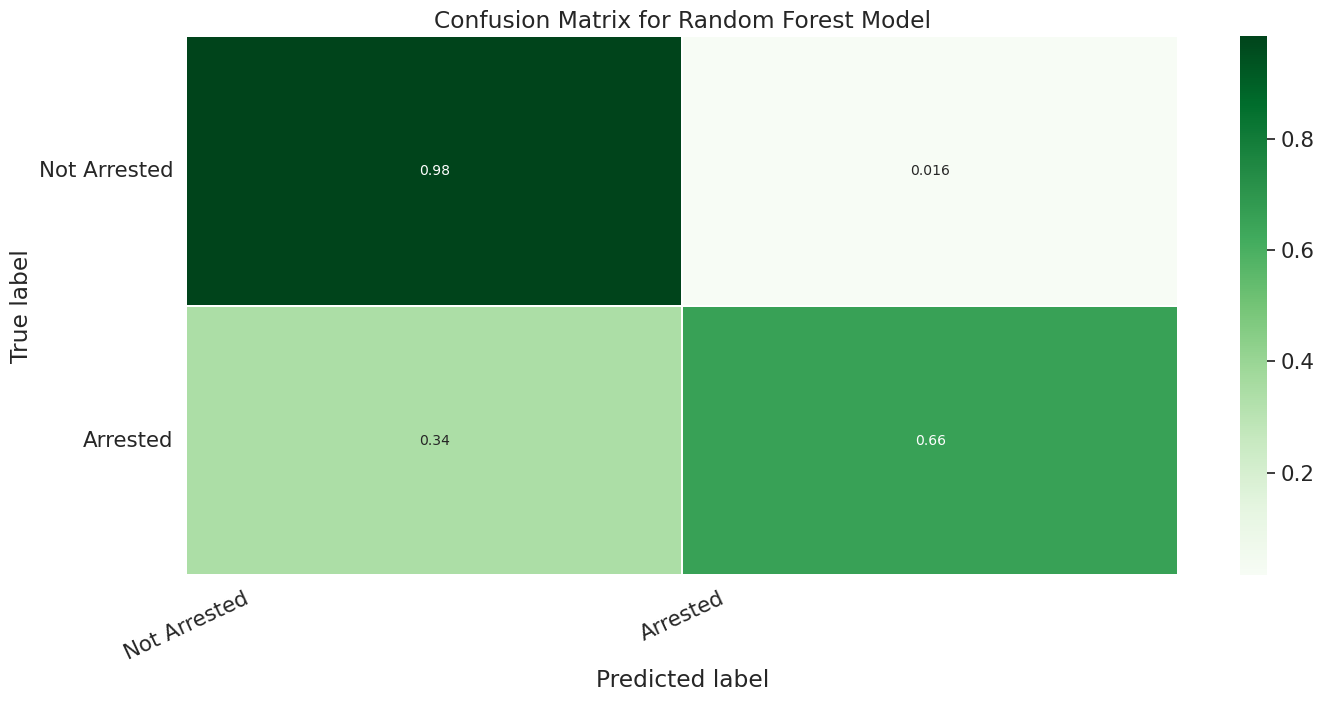

In [19]:
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, test_y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Not Arrested', 'Arrested']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

Visualizing Feature Importance
---
Showing our findings about the most significant features in our dataset using a table and pie chart.

In [20]:
# Annotated feature importance:
pd.DataFrame({"Feature": data_encoded.columns.values, "Importance": rf_model.feature_importances_})

,Feature,Importance
0,Domestic,0.016286
1,Beat,0.018555
2,District,0.008593
3,Ward,0.011066
4,Community Area,0.013572
5,Latitude,0.030199
6,Longitude,0.029989
7,Month,0.011184
8,Day,0.014217
9,Year,0.041693


([<matplotlib.patches.Wedge at 0x7f0a1455e000>,
 [Text(1.0985605407741899, 0.0562560063808294, 'Domestic'),
  Text(1.0858408593676745, 0.17592506395528298, 'Beat'),
  Text(1.0669079315169643, 0.2677824969377067, 'District'),
  Text(1.048345836937726, 0.33312310963867214, 'Ward'),
  Text(1.0194472812797093, 0.41319153027549976, 'Community Area'),
  Text(0.9531848122790887, 0.5490343465034576, 'Latitude'),
  Text(0.8330001335176553, 0.7184085032622933, 'Longitude'),
  Text(0.7333749018731965, 0.819854409820719, 'Month'),
  Text(0.6656862002350127, 0.8757065049528128, 'Day'),
  Text(0.5024211663497663, 0.9785565755763642, 'Year'),
  Text(0.2868142841346923, 1.061949888844245, 'Hour'),
  Text(0.17175154255421227, 1.0865088161769552, 'Weekday'),
  Text(-0.09193153245121201, 1.096151720037501, 'Location Description'),
  Text(-1.0758618531178377, 0.22917520155080615, 'Primary Type'),
  Text(0.45573722696013214, -1.0011511274341598, 'Description')])

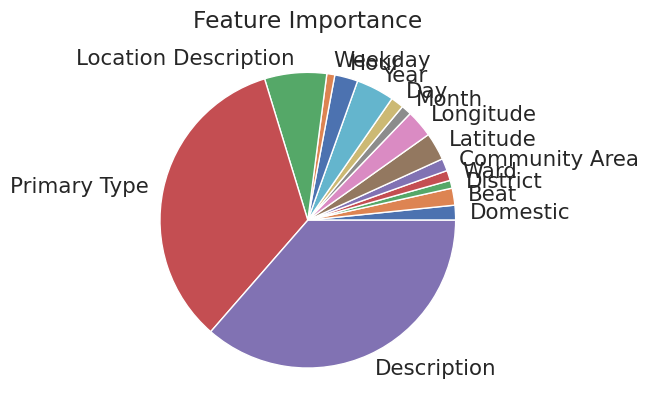

In [21]:
feat_labels = data_encoded.columns.values
feat_importance = rf_model.feature_importances_ * 100

fig, ax = plt.subplots()

plt.title('Feature Importance')
ax.pie(feat_importance, labels=feat_labels)

Saving the Model
---
Here we can save our trained model using the python `pickle` format so we can reload it later

In [ ]:
# save
with open('../models/model.pkl','wb') as f:
    pickle.dump(rf_model,f)